In [1]:
%%time 

# Python 2.7
%matplotlib nbagg
%matplotlib inline 

import os
import sys
print(sys.version)


import cPickle as pickle
import scipy.io
import numpy as np
# import matplotlib.pyplot as plt
# import theano
# import theano.tensor as T
# import lasagne 
# import lasagne.layers as L

import tools as tls

from sklearn.utils import shuffle
from data_loaders import svhn


2.7.12 |Continuum Analytics, Inc.| (default, Jun 29 2016, 11:07:13) [MSC v.1500 64 bit (AMD64)]


Using gpu device 0: GeForce GTX 950M (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5004)


Wall time: 28.3 s


In [2]:
### META - HOW THE PROGRAM WORKS
reduce_dataset_size = False
reduced_size = 10000

reduce_dataset_classes = False
reduced_classes = 3

integet_encoding = False # Are the targets integers or one-hot?

In [3]:
%%time

### LOAD DATA!
# Source: http://ufldl.stanford.edu/housenumbers/


(x_trai, t_trai), (x_test, t_test), (x_vali, t_vali) = \
    svhn.load_supervised(conv=True, extra=False, normalize=True)

# print('train_set', train_set[0].shape, train_set[1].shape)
# print('train_set', test_set[0].shape, test_set[1].shape)
# print('train_set', valid_set[0].shape, valid_set[1].shape)

if(reduce_dataset_size): ## Reduce the total size of the data set
    print('Reduce size')
    x_trai = x_trai[:reduced_size, :]
    t_trai = t_trai[:reduced_size]

    x_test = x_test[:reduced_size, :]
    t_test = t_test[:reduced_size]

    x_vali = x_vali[:reduced_size, :]
    t_vali = t_vali[:reduced_size]

print('train set', x_trai.shape, t_trai.shape)
print('valid set', x_vali.shape, t_vali.shape)
print('test  set', x_test.shape, t_test.shape)



data_loaders\data_helper.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  tmp_data_y = np.zeros((x.shape[0], classes))
data_loaders\data_helper.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  r = np.zeros(classes)
data_loaders\data_helper.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  r[dp] = 1


('train set', (73257L, 3L, 32L, 32L), (73257L, 10L))
('valid set', (5000L, 3L, 32L, 32L), (5000L, 10L))
('test  set', (26032L, 3L, 32L, 32L), (26032L, 10L))
Wall time: 15.4 s


In [4]:
%%time

### REDUCE DATA SET

def bernoullisample(x):
    return np.random.binomial(1,x,size=x.shape).astype(theano.config.floatX)

random_state = 1234

if reduce_dataset_classes:
    print('Reduced dataset, with {} classes'.format(reduce_dataset_classes))
    num_classes = reduced_classes
    idxs_train = []
    idxs_valid = []
    idxs_test = []

    if(integet_encoding): ### IF integer encoding
        idxs_train += np.where(t_trai == i)[0].tolist()
        idxs_valid += np.where(t_vali == i)[0].tolist()
        idxs_test  += np.where(t_test == i)[0].tolist()
    
    else:
        ### IF one-hot encoding
        int_trai = np.where(t_trai == 1)[1]
        int_test = np.where(t_test == 1)[1]
        int_vali = np.where(t_vali == 1)[1]
        
        for i in range(num_classes):
            idxs_train += np.where(int_trai == i)[0].tolist()
            idxs_valid += np.where(int_vali == i)[0].tolist()
            idxs_test  += np.where(int_test == i)[0].tolist()
        

#     x_trai = bernoullisample(x_trai[idxs_train]).astype('float32')
    x_trai = x_trai[idxs_train, :].astype('float32')
    t_trai = t_trai[idxs_train].astype('int32') 
    x_trai, t_trai = shuffle(x_trai, t_trai, random_state=random_state)

#     x_vali = bernoullisample(x_vali[idxs_valid]).astype('float32')
    x_vali = x_vali[idxs_valid].astype('float32')
    t_vali = t_vali[idxs_valid].astype('int32')

#     x_test = bernoullisample(x_test[idxs_test]).astype('float32')
    x_test = x_test[idxs_test].astype('float32')
    t_test = t_test[idxs_test].astype('int32')
else:
    print('Full dataset')
#     x_trai = bernoullisample(x_trai).astype('float32')
    x_trai = x_trai.astype('float32')
    t_trai = t_trai.astype('int32') 
    x_trai, t_trai = shuffle(x_trai, t_trai, random_state=random_state)

#     x_vali = bernoullisample(x_vali).astype('float32')
    x_vali = x_vali.astype('float32')
    t_vali = t_vali.astype('int32')

#     x_test = bernoullisample(x_test).astype('float32')
    x_test = x_test.astype('float32')
    t_test = t_test.astype('int32')
    
x_trai, t_trai = tls.shared_dataset((x_trai, t_trai), borrow=True)
x_vali, t_vali = tls.shared_dataset((x_vali, t_vali), borrow=True)
x_test, t_test = tls.shared_dataset((x_test, t_test), borrow=True)


Full dataset
Wall time: 1.9 s


In [5]:
print('Size of total dataset: {:.2f} MB'.format(
        (
              sys.getsizeof(x_trai.get_value())
            + sys.getsizeof(t_trai.eval())
            + sys.getsizeof(x_vali.get_value())
            + sys.getsizeof(t_vali.eval())
            + sys.getsizeof(x_test.get_value())
            + sys.getsizeof(t_test.eval())
        )/1.0e6))

num_features = x_trai.get_value().shape[-1]
print('num_features {}'.format(num_features))
print('')

print('Train shape: ', x_trai.get_value().shape, t_trai.eval().shape)
print('Valid shape: ', x_vali.get_value().shape, t_vali.eval().shape)
print('Test shape:  ', x_test.get_value().shape, t_test.eval().shape)

print('{}'.format(type(x_trai)))
print('{}'.format(type(x_vali)))
print('{}'.format(type(x_test)))



Size of total dataset: 1285.68 MB
num_features 32

('Train shape: ', (73257L, 3L, 32L, 32L), (73257L, 10L))
('Valid shape: ', (5000L, 3L, 32L, 32L), (5000L, 10L))
('Test shape:  ', (26032L, 3L, 32L, 32L), (26032L, 10L))
<class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>
<class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>
<class 'theano.sandbox.cuda.var.CudaNdarraySharedVariable'>


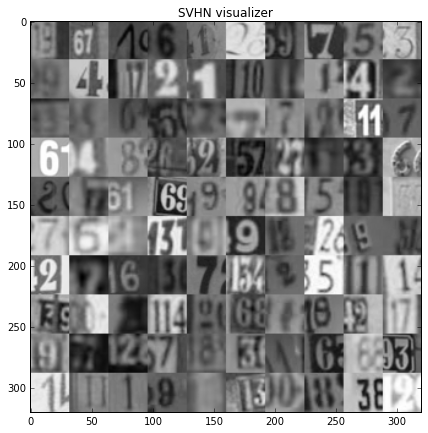

In [6]:
### VISUALIZE DATA, ENSURE THAT EVERYTHING IS OKAY

tls.plot_svhn(x_trai.get_value(), t=10)

In [7]:
### CREATE DATA NAME
name = 'data'
if reduce_dataset_classes:
    name += '_c' + str(reduced_classes)

if reduce_dataset_size:
    name += '_s' + str(reduced_size)
    
full_path = os.path.join(os.getcwd(), 'data')
full_path = os.path.join(full_path, name)
full_path  += '.pkl'
print(full_path)


C:\Users\tokee\Documents\GitHub\02456-VAE\svhn\data\data.pkl


In [8]:
%%time

### SAVE DATA
with open(full_path, 'wb') as f:
    pickle.dump((x_trai, t_trai, x_vali, t_vali, x_test, t_test), 
                f, protocol=pickle.HIGHEST_PROTOCOL)
                

Wall time: 7.24 s


In [9]:
%%time

### LOAD DATA
import cPickle as pickle
with open(full_path, 'rb') as f:
    x_trai, t_trai, x_vali, t_vali, x_test, t_test = pickle.load(f)

print('')
print('Train shape: ', 
      x_trai.get_value().shape, t_trai.eval().shape)
print(type(x_trai))

print('Valid shape: ', 
      x_vali.get_value().shape, t_vali.eval().shape)
print(type(x_vali))

print('Test shape:  ', 
      x_test.get_value().shape, t_test.eval().shape)
print(type(x_test))
print('')

MemoryError: ('Error allocating 900182016 bytes of device memory (CNMEM_STATUS_OUT_OF_MEMORY).', <function CudaNdarray_unpickler at 0x0000000009408518>, (array([[[[ 1.85161304,  2.03099489,  2.21644521, ...,  0.89196914,
           0.89119637,  0.89170229],
         [ 1.86542296,  2.06350946,  2.21194935, ...,  0.8487469 ,
           0.84013259,  0.84818304],
         [ 1.90869319,  2.08602834,  2.20166564, ...,  0.80794835,
           0.80717176,  0.83076662],
         ..., 
         [ 1.7066803 ,  1.95758295,  2.2023232 , ...,  0.9526459 ,
           0.96126813,  0.96371645],
         [ 1.6324352 ,  1.87371206,  2.09889269, ...,  0.94738942,
           0.93892479,  0.95037556],
         [ 1.52809131,  1.7794174 ,  2.02077651, ...,  0.9188931 ,
           0.91191959,  0.91725117]],

        [[ 1.8682332 ,  2.11006498,  2.33058476, ...,  0.83841997,
           0.8001315 ,  0.78520352],
         [ 1.89513159,  2.11296248,  2.28247309, ...,  0.78768241,
           0.75602227,  0.76287937],
         [ 1.94451523,  2.11302209,  2.22343874, ...,  0.76490778,
           0.72696072,  0.73107201],
         ..., 
         [ 1.75411344,  2.0061388 ,  2.2311244 , ...,  0.94659764,
           0.94523346,  0.93731111],
         [ 1.63122094,  1.882635  ,  2.10974693, ...,  0.9185313 ,
           0.92926174,  0.92701215],
         [ 1.54416513,  1.78246343,  2.00241375, ...,  0.89615524,
           0.89547348,  0.89713311]],

        [[ 1.68756068,  1.90803874,  2.13346529, ...,  0.88577259,
           0.85208488,  0.8253355 ],
         [ 1.7207607 ,  1.91680801,  2.11101937, ...,  0.84706122,
           0.82208002,  0.79979736],
         [ 1.7875365 ,  1.96444404,  2.09845233, ...,  0.81169945,
           0.7911306 ,  0.78188097],
         ..., 
         [ 1.71712267,  1.94080853,  2.13917804, ...,  0.90341085,
           0.89445972,  0.89163584],
         [ 1.61033463,  1.83884609,  2.05190325, ...,  0.88413292,
           0.86940163,  0.87075067],
         [ 1.53493679,  1.75817275,  1.96860087, ...,  0.84469658,
           0.84566379,  0.83989948]]],


       [[[ 1.03533149,  0.96175569,  0.89698517, ...,  2.13934326,
           2.18633366,  2.1918149 ],
         [ 1.04658413,  0.70045114,  0.51238412, ...,  2.16080189,
           2.18003941,  2.17739916],
         [ 1.11335015,  0.75527245,  0.54346383, ...,  2.16091084,
           2.16896701,  2.1743052 ],
         ..., 
         [ 1.04390728,  0.62866765,  0.66848755, ...,  2.11609125,
           2.18548894,  2.19516897],
         [ 1.05270946,  0.61380601,  0.63301426, ...,  2.06617403,
           2.11858416,  2.18065   ],
         [ 1.01989055,  0.6222347 ,  0.46665961, ...,  2.00791669,
           2.03475642,  2.12046838]],

        [[ 1.66917694,  1.66414535,  1.59627485, ...,  1.9640125 ,
           1.95910919,  1.9095484 ],
         [ 1.68447244,  1.47863126,  1.33011103, ...,  1.96471846,
           1.9619112 ,  1.93048513],
         [ 1.7084868 ,  1.4503808 ,  1.32483852, ...,  1.99928296,
           1.96873713,  1.95912814],
         ..., 
         [ 1.5884068 ,  1.36128616,  1.42413831, ...,  2.03859282,
           2.04535317,  2.02614331],
         [ 1.62837148,  1.40660322,  1.5135814 , ...,  1.9983716 ,
           2.02947617,  2.03523278],
         [ 1.64619899,  1.48567605,  1.45152223, ...,  1.95251703,
           1.95880699,  2.00843906]],

        [[ 2.24569559,  2.16749024,  2.05420208, ...,  1.77898443,
           1.78825939,  1.73848927],
         [ 2.3556397 ,  2.10580015,  1.95572281, ...,  1.77865732,
           1.7815429 ,  1.74535704],
         [ 2.43580222,  2.24620628,  2.1236732 , ...,  1.77898884,
           1.77413905,  1.76766884],
         ..., 
         [ 2.37168932,  2.30995584,  2.35094166, ...,  1.7421664 ,
           1.76585186,  1.77785635],
         [ 2.31795454,  2.2160356 ,  2.30990076, ...,  1.73663104,
           1.76623094,  1.81550372],
         [ 2.33062077,  2.24180031,  2.21616435, ...,  1.72177064,
           1.71437109,  1.79263866]]],


       [[[ 1.2407304 ,  1.2154218 ,  1.2005955 , ...,  1.28567672,
           1.35445499,  1.35542393],
         [ 1.2506963 ,  1.2127248 ,  1.18501282, ...,  1.31133509,
           1.35395372,  1.36415386],
         [ 1.2398088 ,  1.21224725,  1.18284392, ...,  1.31458628,
           1.35981607,  1.37081945],
         ..., 
         [ 1.18584073,  1.18065405,  1.18877435, ...,  1.19241583,
           1.19728363,  1.20641339],
         [ 1.16873598,  1.17203128,  1.18739617, ...,  1.16514516,
           1.19949615,  1.22878909],
         [ 1.18334973,  1.20391858,  1.19667065, ...,  1.29787529,
           1.25269198,  1.30197012]],

        [[ 1.19159651,  1.15416753,  1.15235639, ...,  1.13211358,
           1.16281593,  1.15822446],
         [ 1.19639611,  1.15813565,  1.1434989 , ...,  1.13699806,
           1.18071425,  1.17738748],
         [ 1.19399524,  1.15732718,  1.14114738, ...,  1.13112247,
           1.17210615,  1.18652248],
         ..., 
         [ 1.20044756,  1.20106924,  1.20865166, ...,  1.14403951,
           1.1994524 ,  1.25584209],
         [ 1.19118345,  1.20482421,  1.20211208, ...,  1.14476311,
           1.22391558,  1.30309403],
         [ 1.19167113,  1.21116471,  1.20778799, ...,  1.27981079,
           1.27188683,  1.31769192]],

        [[ 1.05884373,  1.02723598,  1.01676273, ...,  1.10979736,
           1.16420853,  1.15769827],
         [ 1.08345246,  1.05857003,  1.04073608, ...,  1.0894078 ,
           1.14501882,  1.14382744],
         [ 1.09639883,  1.06350899,  1.05367756, ...,  1.04203928,
           1.09988034,  1.11571395],
         ..., 
         [ 1.21476841,  1.21646082,  1.22473228, ...,  1.22242212,
           1.30590868,  1.33217013],
         [ 1.22232246,  1.23532319,  1.24040127, ...,  1.23032343,
           1.34128833,  1.37553203],
         [ 1.20851946,  1.22056592,  1.23867297, ...,  1.35531986,
           1.3783313 ,  1.44635296]]],


       ..., 
       [[[ 0.78406894,  0.96760905,  1.27513647, ...,  1.77482271,
           1.75929117,  1.7582593 ],
         [ 0.70939553,  0.91543579,  1.24206102, ...,  1.58516192,
           1.56561482,  1.57670164],
         [ 0.59063977,  0.82040268,  1.18322182, ...,  1.37829697,
           1.34959435,  1.36601448],
         ..., 
         [ 1.6556766 ,  1.6335578 ,  1.6285367 , ...,  1.76588023,
           1.65620351,  1.65311933],
         [ 1.5881778 ,  1.58253479,  1.59649575, ...,  1.77115977,
           1.67774534,  1.68830323],
         [ 1.52612138,  1.52659798,  1.55717146, ...,  1.74551582,
           1.64879096,  1.64700603]],

        [[ 1.07386315,  1.23629344,  1.52241051, ...,  1.8404212 ,
           1.85635006,  1.86620879],
         [ 0.97691137,  1.19330609,  1.50249016, ...,  1.63452697,
           1.64832067,  1.69856191],
         [ 0.91275442,  1.15327656,  1.46611416, ...,  1.44820487,
           1.44323885,  1.48548639],
         ..., 
         [ 1.54587007,  1.56599045,  1.57649481, ...,  1.72555923,
           1.66271865,  1.69185042],
         [ 1.48640108,  1.49350333,  1.53789258, ...,  1.74209225,
           1.64639664,  1.67464411],
         [ 1.41792679,  1.40605462,  1.44226861, ...,  1.71055913,
           1.64116442,  1.61359239]],

        [[ 0.80538595,  0.96037132,  1.20188308, ...,  1.77295148,
           1.7706517 ,  1.75411308],
         [ 0.77127892,  0.94087559,  1.19501245, ...,  1.62914526,
           1.60560799,  1.59489059],
         [ 0.76845485,  0.94207406,  1.21796334, ...,  1.49405634,
           1.44493032,  1.45425141],
         ..., 
         [ 1.16804552,  1.20065439,  1.23748147, ...,  1.75165284,
           1.71882772,  1.7391566 ],
         [ 1.10090947,  1.11325181,  1.15276682, ...,  1.72921658,
           1.66373467,  1.69985533],
         [ 1.03400052,  1.05593324,  1.10125077, ...,  1.69493663,
           1.61805201,  1.59569132]]],


       [[[ 0.9459812 ,  0.92354912,  0.86636418, ...,  1.14778173,
           1.16268396,  1.17180037],
         [ 0.94081652,  0.95892262,  0.94391978, ...,  1.13191426,
           1.13418221,  1.1511898 ],
         [ 1.00506651,  1.09773636,  1.17119336, ...,  1.09221017,
           1.11267686,  1.14217412],
         ..., 
         [ 1.17300045,  1.32343435,  1.50041211, ...,  0.93673152,
           0.96454972,  1.0042963 ],
         [ 0.98474473,  1.12678564,  1.31430066, ...,  0.91659904,
           0.96694344,  1.0097785 ],
         [ 0.87244755,  0.98790312,  1.13587821, ...,  0.91498506,
           0.94674128,  0.98371047]],

        [[ 1.00023282,  0.95613152,  0.84740889, ...,  0.8248744 ,
           0.83966583,  0.84623015],
         [ 0.96430832,  0.94246626,  0.89774209, ...,  0.80284363,
           0.82127208,  0.83505374],
         [ 1.02423441,  1.0601424 ,  1.10050774, ...,  0.78559613,
           0.78455889,  0.80266547],
         ..., 
         [ 1.45179307,  1.63804066,  1.85441875, ...,  0.80893457,
           0.81876397,  0.82943469],
         [ 1.26931548,  1.41619802,  1.62556851, ...,  0.78475749,
           0.80550456,  0.81550801],
         [ 1.11385381,  1.24801946,  1.41618621, ...,  0.78852093,
           0.80556697,  0.82218206]],

        [[ 1.2544173 ,  1.24082196,  1.18922937, ...,  0.79395944,
           0.80976242,  0.83366311],
         [ 1.2228533 ,  1.2333622 ,  1.25388837, ...,  0.7751413 ,
           0.79551882,  0.81337035],
         [ 1.23983753,  1.32664907,  1.40782285, ...,  0.77067119,
           0.78826481,  0.80495816],
         ..., 
         [ 1.66789758,  1.84950387,  2.08374572, ...,  0.90568954,
           0.88215441,  0.90425318],
         [ 1.47858906,  1.63809609,  1.86970818, ...,  0.87493706,
           0.86080891,  0.89001542],
         [ 1.34141946,  1.49573576,  1.6757369 , ...,  0.87288392,
           0.87327349,  0.88628221]]],


       [[[ 2.45705509,  2.40437508,  2.39887524, ...,  2.84268355,
           2.66401243,  2.47473145],
         [ 2.47489262,  2.42603016,  2.41667223, ...,  2.8236773 ,
           2.70861006,  2.4978013 ],
         [ 2.50459576,  2.45969868,  2.40672684, ...,  2.52474809,
           2.56145835,  2.42453384],
         ..., 
         [ 2.49830747,  2.40714216,  2.1800673 , ...,  2.21696711,
           2.23006988,  2.26196504],
         [ 2.48259592,  2.42780232,  2.1344552 , ...,  2.13867903,
           2.17533493,  2.31510806],
         [ 2.46165323,  2.39705849,  2.09821534, ...,  2.13655758,
           2.21621704,  2.38466811]],

        [[ 2.31965804,  2.28626347,  2.2699759 , ...,  2.78765583,
           2.60693789,  2.38412237],
         [ 2.32382488,  2.30588031,  2.26722145, ...,  2.77165556,
           2.64364123,  2.42755461],
         [ 2.35888362,  2.31483626,  2.28029132, ...,  2.52270865,
           2.53978968,  2.37968516],
         ..., 
         [ 2.33140826,  2.20499992,  1.96362233, ...,  2.04987121,
           2.06682873,  2.08298755],
         [ 2.29578614,  2.24719477,  1.93031061, ...,  1.94576538,
           1.98096967,  2.11821985],
         [ 2.26979041,  2.20412707,  1.89294827, ...,  1.9219712 ,
           1.99281633,  2.15433621]],

        [[ 2.02174592,  2.07618046,  2.16052938, ...,  2.45785356,
           2.29931474,  2.08638167],
         [ 2.01930976,  2.09244728,  2.15674782, ...,  2.50029278,
           2.36476564,  2.14532399],
         [ 2.02988577,  2.09942245,  2.17167473, ...,  2.3016367 ,
           2.29006028,  2.11318016],
         ..., 
         [ 2.12499166,  2.01257706,  1.79967976, ...,  1.74807727,
           1.76135933,  1.78057671],
         [ 2.10560775,  2.05283952,  1.79512429, ...,  1.63058007,
           1.65166688,  1.76819527],
         [ 2.07666016,  2.00014544,  1.76067531, ...,  1.57972479,
           1.65335453,  1.81182539]]]], dtype=float32),))